In [1]:
#Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Import all the csv in current folder and load in dictionary
initial_data=dict()
initial_buy=['IBM','MSFT','GOOG','AAPL','AMZN']
num_of_ticker=len(initial_buy)
initial_data={file[:-4]:pd.read_csv(file,usecols=['Date','Close','Adj Close']) for r,d,f in os.walk(os.getcwd()) for file in f if ".csv" in file and "USD_JPY_2018" not in file}

In [3]:
#This function calculates dividend for each share and append as a new column to dataframe
def calculate_dividend(row):
    close_ratio=row['Close'].shift().fillna(0)/row['Close'].fillna(0)
    adj_close_ratio=row['Adj Close'].shift().fillna(0)/row['Adj Close'].fillna(0)
    return abs((adj_close_ratio-close_ratio)*row['Close'])


In [4]:
#Add Dividend Column
for ticker,value in initial_data.items():
    value['Dividend']=calculate_dividend(initial_data[ticker])

In [5]:
#Convert to Dataframe and Add Portfolio related columns
share_price_df=pd.concat(initial_data,axis=1,keys=None)
share_price_df['Index','High_Tech_Index']=share_price_df.loc[:,(slice(None),'Close')].mean(axis=1)
for x in range(num_of_ticker):
    share_price_df['Portfolio','Share_'+str(x)+'_Name']=np.NaN
    share_price_df['Portfolio','Share_'+str(x)+'_Quantity']=np.NaN
#share_price_df['Portfolio','Cash']=5000000.00
portfolio_df=share_price_df['Portfolio'].copy()
share_price_df.drop(columns=['Portfolio'],inplace=True)

In [6]:
#This function will help divide cash in equal parts. One can pass Cash as first parameter and number of partitions you want as second parameter.
#Function will return a list of equal parts.
def split_int_equally(number, partitions):
    equal_partitions=list()
    quotient=number//partitions
    remainder=number%partitions
    if(number<partitions):
        raise ValueError('Number should always be greater or equal to partition')
    elif (remainder == 0):
        for i in range(partitions):
            equal_partitions.append(quotient)
    else:
        for i in range(partitions):
            if(i>= (partitions-remainder)):
                equal_partitions.append(quotient+1)
            else:
                equal_partitions.append(quotient)
    return equal_partitions

In [7]:
#This function calculates total dividend accumulated for the day
def total_dividend_for_the_day(price_of_the_day,portfolio_of_the_day, number_of_current_holdings):
    total_dividend=0
    price=price_of_the_day.copy()
    portfolio=portfolio_of_the_day.copy()
    for x in range(number_of_current_holdings):
        ticker=portfolio.loc['Share_'+str(x)+'_Name']
        quantity=portfolio.loc['Share_'+str(x)+'_Quantity']
        dividend=price.loc[ticker,'Dividend']
        total_dividend+=(quantity*dividend)
    return total_dividend

In [8]:
#This function will execute buy order for the day
def buy(price_of_the_day,portfolio_of_the_day,list_to_buy):
    price=price_of_the_day.copy()
    portfolio=portfolio_of_the_day.copy()
    new_cash=0.0
    for distributed_cash,ticker,index in zip(split_int_equally(portfolio['Cash'],len(list_to_buy)),list_to_buy,range(len(list_to_buy))):
        portfolio.loc[['Share_'+str(index)+'_Name','Share_'+str(index)+'_Quantity']]=[ticker,distributed_cash//price.loc[ticker,'Close']]
        new_cash+=distributed_cash%price.loc[ticker,'Close']
        #print(distributed_cash,ticker,index,new_cash)
    portfolio['Cash']=new_cash
    return portfolio

In [9]:
#This function will execute sell order for the day
def sell(price_of_the_day,portfolio_of_the_day):
    price=price_of_the_day.copy()
    portfolio=portfolio_of_the_day.copy()
    sell_cash=portfolio.loc['Cash']+total_dividend_for_the_day(price,portfolio,5)
    for index in range(num_of_ticker):
        quantity=portfolio.loc['Share_'+str(index)+'_Quantity']
        ticker=portfolio.loc['Share_'+str(index)+'_Name']
        sell_cash+=(quantity*price.loc[ticker,'Close'])
        portfolio.loc['Share_'+str(index)+'_Quantity']=0.0
        portfolio.loc['Share_'+str(index)+'_Name']=np.NaN
    portfolio.loc['Cash']=sell_cash
    return portfolio

In [10]:
#This function will return list of shares to buy depending upon what strategy you choose
def get_list_to_buy(currentrow,previousrow,strategy):
    if strategy=='buying low':
        return ((currentrow[:,'Adj Close']-previousrow[:,'Adj Close'])/previousrow[:,'Adj Close']).astype('float64').nsmallest().index.tolist()
    elif strategy=='buying high':
        return ((currentrow[:,'Adj Close']-previousrow[:,'Adj Close'])/previousrow[:,'Adj Close']).astype('float64').nlargest().index.tolist()  
    else:
        raise ValueError("Strategy value should be 'buying high' or 'buying low'")

In [11]:
#This function returns MTM until the day the paramter has been passsed
def MTM(price_of_the_day,portfolio_of_the_day):
    price=price_of_the_day.copy()
    portfolio=portfolio_of_the_day.copy()
    sell_cash=portfolio.loc['Cash']+total_dividend_for_the_day(price,portfolio,5)
    for index in range(num_of_ticker):
        quantity=portfolio.loc['Share_'+str(index)+'_Quantity']
        ticker=portfolio.loc['Share_'+str(index)+'_Name']
        sell_cash+=(quantity*price.loc[ticker,'Close'])
    return sell_cash

In [12]:
def portfolio_management_algorithm(initial_cash, initial_buy_list, rebalance_days, rebalance_strategy):
    portfolio_df[:]=np.NaN
    portfolio_df['Cash']=initial_cash
    portfolio_df['MTM']=0.0
    for i in range(len(share_price_df)):
        if i==0:
            ser=buy(share_price_df.loc[i],portfolio_df.loc[i],initial_buy_list)
            portfolio_df.loc[i]=ser
            print("Initial Buying is done. Row {0} in portfolio is updated".format(i))
        elif i%rebalance_days!=0:
            portfolio_df.loc[i]=portfolio_df.loc[i-1]
            portfolio_df.loc[i,'Cash']+=total_dividend_for_the_day(share_price_df.loc[i],portfolio_df.loc[i],len(initial_buy_list))
            print("No New Buying. Dividends have been added to cash. Row {0} in portfolio is updated".format(i))
        elif i%rebalance_days==0:
            portfolio_df.loc[i]=portfolio_df.loc[i-1]
            sell_ser=sell(share_price_df.loc[i],portfolio_df.loc[i])
            portfolio_df.loc[i]=sell_ser
            list_to_buy=get_list_to_buy(share_price_df.loc[i],share_price_df.loc[i-rebalance_days],rebalance_strategy)
            buy_ser=buy(share_price_df.loc[i],portfolio_df.loc[i],list_to_buy)
            portfolio_df.loc[i]=buy_ser
            print("{1} stocks have been bought . Row {0} in portfolio is updated".format(i,list_to_buy))
        portfolio_df.loc[i,'MTM']=MTM(share_price_df.loc[i],portfolio_df.loc[i])

In [13]:
portfolio_management_algorithm(5000000,initial_buy,5,'buying low')

Initial Buying is done. Row 0 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 1 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 2 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 3 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 4 in portfolio is updated
['AAPL', 'SAP', 'MSFT', 'FB', 'GOOG'] stocks have been bought . Row 5 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 6 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 7 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 8 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 9 in portfolio is updated
['FB', 'SAP', 'MSFT', 'GOOG', 'ORCL'] stocks have been bought . Row 10 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 11 in portfolio is updated
No New Buying. Dividends have been a

['FB', 'GOOG', 'MSFT', 'AAPL', 'NFLX'] stocks have been bought . Row 110 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 111 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 112 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 113 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 114 in portfolio is updated
['ORCL', 'IBM', 'AAPL', 'SAP', 'MSFT'] stocks have been bought . Row 115 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 116 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 117 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 118 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 119 in portfolio is updated
['TSLA', 'ORCL', 'GOOG', 'IBM', 'AMZN'] stocks have been bought . Row 120 in portfolio is updated
No New Buying. Dividends have been added to cash. Ro

['IBM', 'AMZN', 'NFLX', 'AAPL', 'GOOG'] stocks have been bought . Row 210 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 211 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 212 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 213 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 214 in portfolio is updated
['AAPL', 'FB', 'GOOG', 'SAP', 'ORCL'] stocks have been bought . Row 215 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 216 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 217 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 218 in portfolio is updated
No New Buying. Dividends have been added to cash. Row 219 in portfolio is updated
['NFLX', 'AAPL', 'AMZN', 'MSFT', 'SAP'] stocks have been bought . Row 220 in portfolio is updated
No New Buying. Dividends have been added to cash. Ro

In [14]:
#Load USD to JPY conversion data
#Add Close column to portfolio 
#Wherever data for the date is not present, update with previous date data
USD_JPY={file[:-4]:pd.read_csv(file,usecols=['Date','Close']) for r,d,f in os.walk(os.getcwd()) for file in f if "USD_JPY_2018" in file}
portfolio_df['USD_JPY']=pd.merge(initial_data['IBM']['Date'],USD_JPY['USD_JPY_2018']['Close'],how='left',left_on=pd.to_datetime(initial_data['IBM']['Date']),right_on=pd.to_datetime(USD_JPY['USD_JPY_2018']['Date']))['Close']
while len(portfolio_df.loc[portfolio_df['USD_JPY'].isnull()])>0:
    portfolio_df.loc[:,'USD_JPY'].replace(to_replace=np.NaN,value=portfolio_df['USD_JPY'].shift(),inplace=True)
portfolio_df['MTM_JPY']=portfolio_df['MTM']*portfolio_df['USD_JPY']

In [15]:

share_price_df.to_csv('Share Price DF for QC check')
share_price_df.head()

AAPL                                          AMZN               \
         Date       Close   Adj Close  Dividend        Date        Close   
0  2018-01-02  172.259995  167.701889  0.000000  2018-01-02  1189.010010   
1  2018-01-03  172.229996  167.672668  0.000016  2018-01-03  1204.199951   
2  2018-01-04  173.029999  168.451508  0.000006  2018-01-04  1209.589966   
3  2018-01-05  175.000000  170.369385  0.000004  2018-01-05  1229.140015   
4  2018-01-08  174.350006  169.736588  0.000002  2018-01-08  1246.869995   

                                 FB              ...      ORCL         SAP  \
     Adj Close Dividend        Date       Close  ...  Dividend        Date   
0  1189.010010      0.0  2018-01-02  181.419998  ...  0.000000  2018-01-02   
1  1204.199951      0.0  2018-01-03  184.669998  ...  0.000001  2018-01-03   
2  1209.589966      0.0  2018-01-04  184.330002  ...  0.000004  2018-01-04   
3  1229.140015      0.0  2018-01-05  186.850006  ...  0.000006  2018-01-05   
4  1246.869995      0.0  2018-01-08  188.279999  ...  0.000008  2018-01-08   

                                               TSLA                          \
        Close   Adj Close      Dividend        Date       Close   Adj Close   
0  112.389999  109.207581  0.000000e+00  2018-01-02  320.529999  320.529999   
1  113.309998  110.101524  5.562469e-06  2018-01-03  317.250000  317.250000   
2  115.050003  111.792259  2.039416e-07  2018-01-04  314.619995  314.619995   
3  116.330002  113.036011  2.728303e-06  2018-01-05  316.579987  316.579987   
4  114.800003  111.549332  3.471553e-06  2018-01-08  336.410004  336.410004   

                     Index  
  Dividend High_Tech_Index  
0      0.0      352.851001  
1      0.0      357.173993  
2      0.0      358.563999  
3      0.0      363.527000  
4      0.0      368.042995  

[5 rows x 41 columns]

In [16]:
portfolio_df.head()

,Share_0_Name,Share_0_Quantity,Share_1_Name,Share_1_Quantity,Share_2_Name,Share_2_Quantity,Share_3_Name,Share_3_Quantity,Share_4_Name,Share_4_Quantity,Cash,MTM,USD_JPY,MTM_JPY
0,IBM,6482.0,MSFT,11634.0,GOOG,938.0,AAPL,5805.0,AMZN,841.0,1312.545517,5.000000e+06,112.511,5.625550e+08
1,IBM,6482.0,MSFT,11634.0,GOOG,938.0,AAPL,5805.0,AMZN,841.0,1312.776643,5.061135e+06,112.751,5.706480e+08
2,IBM,6482.0,MSFT,11634.0,GOOG,938.0,AAPL,5805.0,AMZN,841.0,1313.117963,5.103638e+06,113.054,5.769867e+08
3,IBM,6482.0,MSFT,11634.0,GOOG,938.0,AAPL,5805.0,AMZN,841.0,1313.467721,5.164050e+06,113.054,5.838165e+08
4,IBM,6482.0,MSFT,11634.0,GOOG,938.0,AAPL,5805.0,AMZN,841.0,1313.687237,5.187005e+06,112.648,5.843057e+08


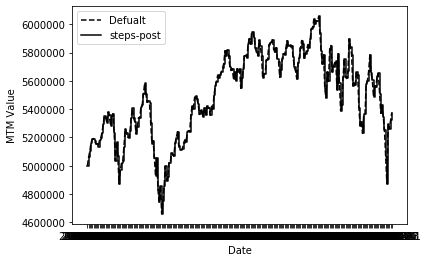

0      5.000000e+06
1      5.061135e+06
2      5.103638e+06
3      5.164050e+06
4      5.187005e+06
           ...     
246    4.872863e+06
247    5.295794e+06
248    5.261191e+06
249    5.321285e+06
250    5.376076e+06
Name: MTM, Length: 251, dtype: float64

In [17]:
#MTM Plot mathlab plot

# plots two dimensional data (x,y)
plt.plot(share_price_df['AAPL']['Date'],portfolio_df['MTM'], 'k--', label='Defualt') 
plt.plot(share_price_df['AAPL']['Date'],portfolio_df['MTM'], 'k-', drawstyle= 'steps-post', label='steps-post') 
plt.legend(loc='best')
# plots data to a power curver
# plt.plot(share_price_df['AAPL']['Date'],np.power(portfolio_df['MTM'],1.3))


#plots data to a sin curve
# plt.plot(share_price_df['AAPL']['Date'],np.sin(portfolio_df['MTM']))


plt.ylabel('MTM Value')
plt.xlabel('Date')
plt.show()
portfolio_df['MTM']

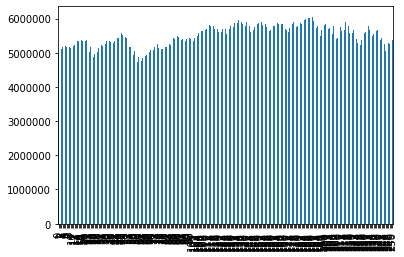

In [18]:
#MTM - DF plot

# plots two dimensional data (x,y)

# portfolio_df['MTM'].plot()
portfolio_df['MTM'].plot.bar()

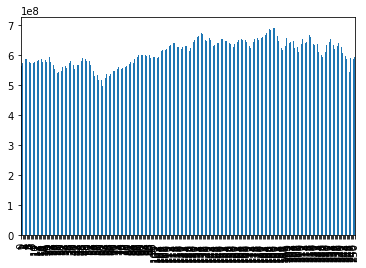

In [19]:
# portfolio_df['MTM_JPY'].plot()
portfolio_df['MTM_JPY'].plot.bar()

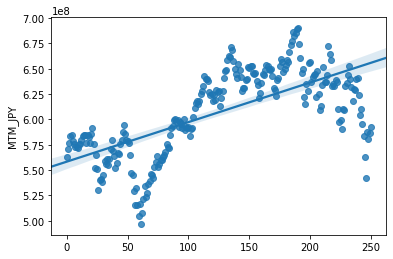

In [20]:
# regression plot of #days and MTM JPY

x = np.array(portfolio_df['MTM_JPY'].index)
sns.regplot(x,portfolio_df['MTM_JPY'])